In [14]:
data_folder = "./Dataset"

Contoh Model dari https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

---------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np

import os
import pathlib
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.utils import np_utils, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# creating Dataframe using all the 4 dataframes we created so far.
path = pathlib.Path("Dataset") / "data"
data_dict = {
    "paths":[],
    "labels":[],
}
for audio_path in path.glob("*/*"):
    label = str(audio_path).split(os.sep)[-2]
    data_dict["paths"].append(audio_path)
    data_dict["labels"].append(label)

data_path = pd.DataFrame(data_dict)
data_path.to_csv("data_path_v2.csv",index=False)
data_path.head()

,paths,labels
0,Dataset\data\angry\03-01-05-01-01-01-01.wav,angry
1,Dataset\data\angry\03-01-05-01-01-01-02.wav,angry
2,Dataset\data\angry\03-01-05-01-01-01-03.wav,angry
3,Dataset\data\angry\03-01-05-01-01-01-04.wav,angry
4,Dataset\data\angry\03-01-05-01-01-01-05.wav,angry


In [3]:
emotions = os.listdir(pathlib.Path("Dataset") / "data")
emotions

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

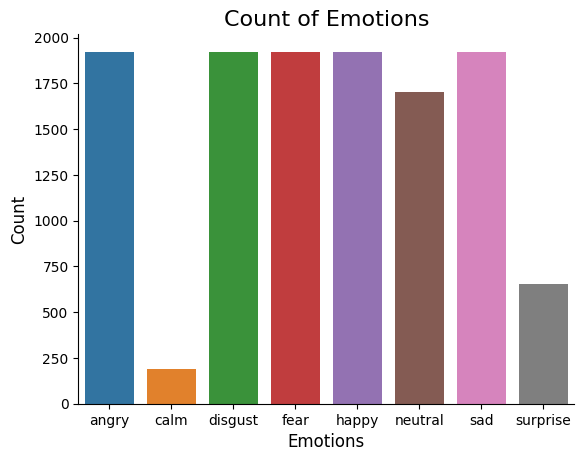

In [3]:
data_path['labels'] = data_path['labels'].astype('category')
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='labels')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [3]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [4]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    # return librosa.effects.pitch_shift(data, sr=sampling_rate, pitch_factor)
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [5]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = librosa.feature.zero_crossing_rate(y=data)
    zcr_mean = np.mean(zcr, axis=1)
    zcr_min = np.min(zcr, axis=1)
    zcr_max = np.max(zcr, axis=1)
    zcr_feature = np.concatenate((zcr_min, zcr_mean, zcr_max))

    # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    
    chroma_stft = librosa.feature.chroma_stft(S=librosa.stft(data), sr=sample_rate)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)
    chroma_stft_min = np.min(chroma_stft, axis=1)
    chroma_stft_max = np.max(chroma_stft, axis=1)
    chroma_stft_feature = np.concatenate((chroma_stft_min, chroma_stft_mean, chroma_stft_max))

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_min = np.min(mfcc, axis=1)
    mfcc_max = np.max(mfcc, axis=1)
    mfcc_feature = np.concatenate((mfcc_min, mfcc_mean, mfcc_max))

    # Root Mean Square Value
    # rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    # result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    mel_mean = np.mean(mel, axis=1)
    mel_min = np.min(mel, axis=1)
    mel_max = np.max(mel, axis=1)
    mel_feature = np.concatenate((mel_min, mel_mean, mel_max))
    
    result = np.concatenate((zcr_feature, chroma_stft_feature, mfcc_feature, mel_feature))
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [38]:

def extract_2d_features(data, sample_rate):
    # ZCR
    # result = np.array([])
    # zcr = librosa.feature.zero_crossing_rate(y=data)
    # zcr_mean = np.mean(zcr, axis=1)
    # zcr_min = np.min(zcr, axis=1)
    # zcr_max = np.max(zcr, axis=1)
    # zcr_feature = np.concatenate((zcr_min, zcr_mean, zcr_max))

    # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    
    # chroma_stft = librosa.feature.chroma_stft(S=librosa.stft(data), sr=sample_rate)
    # chroma_stft_mean = np.mean(chroma_stft, axis=1)
    # chroma_stft_min = np.min(chroma_stft, axis=1)
    # chroma_stft_max = np.max(chroma_stft, axis=1)
    # chroma_stft_feature = np.concatenate((chroma_stft_min, chroma_stft_mean, chroma_stft_max))

    # MFCC
    # mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    # mfcc_mean = np.mean(mfcc, axis=1)
    # mfcc_min = np.min(mfcc, axis=1)
    # mfcc_max = np.max(mfcc, axis=1)
    # mfcc_feature = np.concatenate((mfcc_min, mfcc_mean, mfcc_max))

    # Root Mean Square Value
    # rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    # result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=np.abs(librosa.stft(data)), sr=sample_rate)
    # mel_mean = np.mean(mel, axis=1)
    # mel_min = np.min(mel, axis=1)
    # mel_max = np.max(mel, axis=1)
    # mel_feature = np.concatenate((mel_min, mel_mean, mel_max))
    
    # result = np.concatenate((zcr, chroma_stft, mfcc, mel))
    # return result
    return np.array(mel)

def get_2d_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normalize the audio data
    
    # without augmentation
    normal_data = extract_2d_features(data, sample_rate)
    # result = np.array(res1)
    
    # data with noise
    noise_data = extract_2d_features(noise(data), sample_rate)
    
    # data with stretching and pitching
    new_data = stretch(data)
    stretch_pitch_data = extract_2d_features(pitch(new_data, sample_rate), sample_rate)
    
    return normal_data, noise_data, stretch_pitch_data
    # return normal_data

In [36]:
ds = tf.data.Dataset.from_tensor_slices([str(data_path.iloc[0,0])])
ds = ds.map(get_2d_features)

InvalidArgumentError: in user code:

    File "C:\Users\abdul\AppData\Local\Temp\ipykernel_12476\2037687531.py", line 45, in get_2d_features  *
        str_path = sess.run(path)

    InvalidArgumentError: Graph execution error:
    
    Detected at node 'path' defined at (most recent call last):
        File "<frozen runpy>", line 198, in _run_module_as_main
        File "<frozen runpy>", line 88, in _run_code
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
          app.launch_new_instance()
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
          app.start()
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start
          self.io_loop.start()
        File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
          self.asyncio_loop.run_forever()
        File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever
          self._run_once()
        File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once
          handle._run()
        File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
          self._context.run(self._callback, *self._args)
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
          await self.process_one()
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one
          await dispatch(*args)
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
          await result
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
          reply_content = await reply_content
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
          res = shell.run_cell(
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
          return super().run_cell(*args, **kwargs)
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
          result = self._run_cell(
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
          result = runner(coro)
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
          coro.send(None)
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
          has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
          if await self.run_code(code, result, async_=asy):
        File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
          exec(code_obj, self.user_global_ns, self.user_ns)
        File "C:\Users\abdul\AppData\Local\Temp\ipykernel_12476\3844274117.py", line 2, in <module>
          ds = ds.map(get_2d_features)
        File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\core\function\polymorphism\function_type.py", line 301, in placeholder_arguments
          arguments[parameter.name] = parameter.type_constraint.placeholder_value(
    Node: 'path'
    You must feed a value for placeholder tensor 'path' with dtype string
    	 [[{{node path}}]]
    
    Original stack trace for 'path':
      File "<frozen runpy>", line 198, in _run_module_as_main
      File "<frozen runpy>", line 88, in _run_code
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
        app.launch_new_instance()
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
        app.start()
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start
        self.io_loop.start()
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
        self.asyncio_loop.run_forever()
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever
        self._run_once()
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once
        handle._run()
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
        self._context.run(self._callback, *self._args)
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
        await self.process_one()
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one
        await dispatch(*args)
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
        await result
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
        reply_content = await reply_content
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
        res = shell.run_cell(
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
        return super().run_cell(*args, **kwargs)
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
        result = self._run_cell(
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
        result = runner(coro)
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
        coro.send(None)
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
        has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
        if await self.run_code(code, result, async_=asy):
      File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
        exec(code_obj, self.user_global_ns, self.user_ns)
      File "C:\Users\abdul\AppData\Local\Temp\ipykernel_12476\3844274117.py", line 2, in <module>
        ds = ds.map(get_2d_features)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 2240, in map
        return map_op._map_v2(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\map_op.py", line 37, in _map_v2
        return _MapDataset(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\map_op.py", line 107, in __init__
        self._map_func = structured_function.StructuredFunctionWrapper(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py", line 261, in __init__
        self._function = fn_factory()
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 232, in get_concrete_function
        concrete_function = self._get_concrete_function_garbage_collected(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 202, in _get_concrete_function_garbage_collected
        concrete_function, _ = self._maybe_define_concrete_function(args, kwargs)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 166, in _maybe_define_concrete_function
        return self._maybe_define_function(args, kwargs)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 396, in _maybe_define_function
        concrete_function = self._create_concrete_function(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 300, in _create_concrete_function
        func_graph_module.func_graph_from_py_func(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\func_graph.py", line 1214, in func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py", line 238, in wrapped_fn
        ret = wrapper_helper(*args)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py", line 169, in wrapper_helper
        ret = autograph.tf_convert(self._func, ag_ctx)(*nested_args)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
        return fn(*args, **kwargs)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 894, in __call__
        result = self._call(*args, **kwds)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 942, in _call
        self._initialize(args, kwds, add_initializers_to=initializers)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 763, in _initialize
        self._variable_creation_fn    # pylint: disable=protected-access
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 171, in _get_concrete_function_internal_garbage_collected
        concrete_function, _ = self._maybe_define_concrete_function(args, kwargs)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 166, in _maybe_define_concrete_function
        return self._maybe_define_function(args, kwargs)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 387, in _maybe_define_function
        placeholder_bound_args = target_func_type.placeholder_arguments(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\core\function\polymorphism\function_type.py", line 301, in placeholder_arguments
        arguments[parameter.name] = parameter.type_constraint.placeholder_value(
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\tensor_spec.py", line 227, in placeholder_value
        placeholder = self._graph_placeholder(context_graph, name=name)
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\tensor_spec.py", line 255, in _graph_placeholder
        op = graph._create_op_internal(  # pylint: disable=protected-access
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\func_graph.py", line 707, in _create_op_internal
        return super()._create_op_internal(  # pylint: disable=protected-access
      File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\ops.py", line 3814, in _create_op_internal
        ret = Operation(
    


Original stack trace for 'path':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start
    self.io_loop.start()
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever
    self._run_once()
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once
    handle._run()
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
    await self.process_one()
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one
    await dispatch(*args)
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
    await result
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
    reply_content = await reply_content
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
    res = shell.run_cell(
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
    result = self._run_cell(
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
    result = runner(coro)
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\abdul\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\abdul\AppData\Local\Temp\ipykernel_12476\3844274117.py", line 2, in <module>
    ds = ds.map(get_2d_features)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 2240, in map
    return map_op._map_v2(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\map_op.py", line 37, in _map_v2
    return _MapDataset(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\map_op.py", line 107, in __init__
    self._map_func = structured_function.StructuredFunctionWrapper(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py", line 261, in __init__
    self._function = fn_factory()
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 232, in get_concrete_function
    concrete_function = self._get_concrete_function_garbage_collected(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 202, in _get_concrete_function_garbage_collected
    concrete_function, _ = self._maybe_define_concrete_function(args, kwargs)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 166, in _maybe_define_concrete_function
    return self._maybe_define_function(args, kwargs)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 396, in _maybe_define_function
    concrete_function = self._create_concrete_function(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 300, in _create_concrete_function
    func_graph_module.func_graph_from_py_func(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\func_graph.py", line 1214, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py", line 238, in wrapped_fn
    ret = wrapper_helper(*args)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py", line 169, in wrapper_helper
    ret = autograph.tf_convert(self._func, ag_ctx)(*nested_args)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 942, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 763, in _initialize
    self._variable_creation_fn    # pylint: disable=protected-access
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 171, in _get_concrete_function_internal_garbage_collected
    concrete_function, _ = self._maybe_define_concrete_function(args, kwargs)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 166, in _maybe_define_concrete_function
    return self._maybe_define_function(args, kwargs)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py", line 387, in _maybe_define_function
    placeholder_bound_args = target_func_type.placeholder_arguments(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\core\function\polymorphism\function_type.py", line 301, in placeholder_arguments
    arguments[parameter.name] = parameter.type_constraint.placeholder_value(
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\tensor_spec.py", line 227, in placeholder_value
    placeholder = self._graph_placeholder(context_graph, name=name)
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\tensor_spec.py", line 255, in _graph_placeholder
    op = graph._create_op_internal(  # pylint: disable=protected-access
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\func_graph.py", line 707, in _create_op_internal
    return super()._create_op_internal(  # pylint: disable=protected-access
  File "c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\framework\ops.py", line 3814, in _create_op_internal
    ret = Operation(


In [37]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [7]:
X, Y = [], []
numOfSongsPath = data_path.shape[0]
num = 0
# Initial call to print 0% progress
printProgressBar(0, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = 'Complete', length = 50)
for path, emotion in zip(data_path.paths, data_path.labels):
    num += 1
    feature = get_features(path)
    l = len(feature)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    printProgressBar(num, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = f'{str(path)[:20]}... Complete', length = 50)

NameError: name 'get_features' is not defined

In [39]:
X_2d, Y_2d = [], []
numOfSongsPath = data_path.shape[0]
num = 0
# Initial call to print 0% progress
printProgressBar(0, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = 'Complete', length = 50)
for path, emotion in zip(data_path.paths, data_path.labels):
    num += 1
    feature = get_2d_features(path)
    l = len(feature)
    for ele in feature:
        X_2d.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y_2d.append(emotion)
    printProgressBar(num, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = f'{str(path)[:20]}... Complete', length = 50)

Progress (12162/12162): |██████████████████████████████████████████████████| 100.0% Dataset\data\surpris... Complete


In [44]:
# import pickle
# pickle.dump(X_2d, open('D:\\X_2d.pkl', 'wb'))
# del X_2d
del Y_2d

In [117]:
Features_2d = pd.DataFrame(X_2d)
Features_2d['labels'] = Y_2d
Features_2d.to_csv('features_2d.csv', index=False)
Features_2d.head()

MemoryError: Unable to allocate 35.7 GiB for an array with shape (36486, 1025, 128, 1) and data type float64

In [118]:
X_2d[1].shape

(1025, 128, 1)

In [120]:
x_2d_train, x_2d_val_2d_test, y_2d_train, y_2d_val_2d_test = train_test_split(np.array(X_2d), np.array(Y_2d), random_state=123, shuffle=True, stratify=Y, test_size=0.25)
x_2d_test, x_2d_val, y_2d_test, y_2d_val = train_test_split(x_val_test, y_val_test, random_state=123, shuffle=True, stratify=y_val_test, test_size=0.5)
# x_2d_train.shape, y_2d_train.shape, x_2d_val.shape, y_2d_val.shape, x_2d_test.shape, y_2d_test.shape

In [ ]:
mapper = lambda label: np.argmax(label == np.array(emotions))
y_2d_train = np.array(list(map(mapper, y_2d_train)))
y_2d_val = np.array(list(map(mapper, y_2d_val)))
y_2d_test = np.array(list(map(mapper, y_2d_test)))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_2d_train, y_2d_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_2d_val, y_2d_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_2d_test, y_2d_test))

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [125]:
for feature, _ in train_ds.take(1):
  input_shape = feature.shape
print('Input shape:', input_shape)
num_labels = len(emotions)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = Sequential([
    keras.layers.Input(shape=input_shape),
    # Downsample the input.
    keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels),
])

model.summary()


Input shape: (1025, 128, 1)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

In [23]:
len(X), len(Y), data_path.labels.shape

(36486, 36486, (12162,))

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features_v2.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,474,475,476,477,478,479,480,481,482,labels
0,0.021484+0.000000j,0.215391+0.000000j,0.846680+0.000000j,-0.970763+0.194234j,-0.892638+0.450775j,-0.999959+0.009065j,-0.975525-0.203940j,-0.986956+0.160989j,-0.848758+0.506919j,-0.931217-0.364467j,...,0.005162+0.000000j,0.002717+0.000000j,0.002262+0.000000j,0.003146+0.000000j,0.001329+0.000000j,0.002986+0.000000j,0.009702+0.000000j,0.007743+0.000000j,0.000340+0.000000j,angry
1,0.040039+0.000000j,0.246388+0.000000j,0.521484+0.000000j,-0.999994+0.003414j,-0.959427-0.256119j,-0.996731+0.080796j,-0.997243+0.074207j,-0.995000+0.099872j,-0.778952-0.043514j,-0.950413-0.310991j,...,0.005212+0.000000j,0.002888+0.000000j,0.002589+0.000000j,0.003069+0.000000j,0.001410+0.000000j,0.002944+0.000000j,0.010250+0.000000j,0.007926+0.000000j,0.000436+0.000000j,angry
2,0.039551+0.000000j,0.177398+0.000000j,0.500000+0.000000j,-0.996559-0.082885j,-0.989573-0.144036j,-0.929922-0.367757j,-0.999775+0.021220j,-0.948390+0.262060j,-0.997035-0.076945j,-0.983949-0.178452j,...,0.001818+0.000000j,0.000726+0.000000j,0.000378+0.000000j,0.000375+0.000000j,0.000265+0.000000j,0.000346+0.000000j,0.000345+0.000000j,0.000146+0.000000j,0.000089+0.000000j,angry
3,0.000000+0.000000j,0.229605+0.000000j,0.787598+0.000000j,-0.814762-0.579796j,-0.877469+0.019409j,-0.815212-0.093891j,-0.982838-0.184472j,-0.989914-0.141666j,-0.924982-0.380010j,-0.999846-0.017538j,...,0.005419+0.000000j,0.004542+0.000000j,0.001350+0.000000j,0.002439+0.000000j,0.001855+0.000000j,0.001153+0.000000j,0.002825+0.000000j,0.001441+0.000000j,0.000226+0.000000j,angry
4,0.054199+0.000000j,0.306957+0.000000j,0.515625+0.000000j,-0.979647+0.116168j,-0.730122-0.520453j,-0.982236+0.000117j,-0.927241-0.374464j,-0.999653+0.026356j,-0.807488+0.346985j,-0.995084-0.099031j,...,0.005981+0.000000j,0.003975+0.000000j,0.002007+0.000000j,0.002888+0.000000j,0.002704+0.000000j,0.002086+0.000000j,0.003641+0.000000j,0.002331+0.000000j,0.001507+0.000000j,angry


In [7]:
Features = pd.read_csv('features_v2.csv')

In [9]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
X

array([['(0.021484375+0j)', '(0.2153908058449074+0j)',
        '(0.8466796875+0j)', ..., '(0.009701820090413094+0j)',
        '(0.007742794696241617+0j)', '(0.00034039089223369956+0j)'],
       ['(0.0400390625+0j)', '(0.24638762297453703+0j)',
        '(0.521484375+0j)', ..., '(0.010250222247534068+0j)',
        '(0.007926047675621694+0j)', '(0.00043591614046098237+0j)'],
       ['(0.03955078125+0j)', '(0.17739800347222223+0j)', '(0.5+0j)',
        ..., '(0.00034520539338700473+0j)', '(0.0001455834717489779+0j)',
        '(8.906293078325689e-05+0j)'],
       ...,
       ['(0.01416015625+0j)', '(0.0917202818627451+0j)',
        '(0.38623046875+0j)', ..., '(0.00035567962913773954+0j)',
        '(0.00047881671343930066+0j)', '(1.0143921826966107e-05+0j)'],
       ['(0.02978515625+0j)', '(0.12155330882352941+0j)',
        '(0.4794921875+0j)', ..., '(0.0005929124405620816+0j)',
        '(0.0005889727185627246+0j)', '(0.0004009087196465581+0j)'],
       ['(0.0166015625+0j)', '(0.107315063476

In [10]:
# As this is a multiclass classification problem onehotencoding our Y.
# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
for i in range(X.shape[0]):
    X[i] = np.array(list(map(lambda x: eval(x), X[i]))).real
X

array([[0.021484375, 0.2153908058449074, 0.8466796875, ...,
        0.009701820090413094, 0.007742794696241617,
        0.00034039089223369956],
       [0.0400390625, 0.24638762297453703, 0.521484375, ...,
        0.010250222247534068, 0.007926047675621694,
        0.00043591614046098237],
       [0.03955078125, 0.17739800347222223, 0.5, ...,
        0.00034520539338700473, 0.0001455834717489779,
        8.906293078325689e-05],
       ...,
       [0.01416015625, 0.0917202818627451, 0.38623046875, ...,
        0.00035567962913773954, 0.00047881671343930066,
        1.0143921826966107e-05],
       [0.02978515625, 0.12155330882352941, 0.4794921875, ...,
        0.0005929124405620816, 0.0005889727185627246,
        0.0004009087196465581],
       [0.0166015625, 0.1073150634765625, 0.39111328125, ...,
        0.0006192887085489929, 0.00015031314978841692,
        3.2854482014954556e-06]], dtype=object)

In [5]:
import pickle
pickle.dump(encoder, open('encoder.pkl', 'wb'))

In [73]:
# splitting data
x_train, x_val_test, y_train, y_val_test = train_test_split(np.asarray(X).astype('float64'), Y, random_state=123, shuffle=True, stratify=Y, test_size=0.35)
x_test, x_val, y_test, y_val = train_test_split(x_val_test, y_val_test, random_state=123, shuffle=True, stratify=y_val_test, test_size=0.5)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape


((23715, 483), (23715,), (6386, 483), (6386,), (6385, 483), (6385,))

In [82]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# map the labels
def map_label(x, y):
    features = tf.cast(x, tf.float64)
    label_id = tf.argmax(tf.cast((y == emotions), tf.int32))
    return tf.expand_dims(features,1), label_id

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(
    map_func=map_label,
    num_parallel_calls=AUTOTUNE
)
val_ds = val_ds.map(
    map_func=map_label,
    num_parallel_calls=AUTOTUNE
)
test_ds = test_ds.map(
    map_func=map_label,
    num_parallel_calls=AUTOTUNE
)

In [62]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [63]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [74]:
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [75]:
label= y_train[0]
np.argmax(label == np.array(emotions))
np.array(emotions) == label

array([False, False, False,  True, False, False, False, False])

In [76]:
mapper = lambda label: np.argmax(label == np.array(emotions))
y_train = np.array(list(map(mapper, y_train)))
y_val = np.array(list(map(mapper, y_val)))
y_test = np.array(list(map(mapper, y_test)))

In [77]:
max(y_train)

7

In [56]:
# for feature, _ in train_ds.take(1):
#   input_shape = feature.shape
num_labels = len(emotions)
input_shape = (x_train.shape[1], 1)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
norm_layer.adapt(data=x_train)

model = Sequential([
    keras.layers.Input(shape=input_shape),
    norm_layer,
    Conv1D(64, kernel_size=3,  padding="same", activation='relu'),
    Conv1D(32, kernel_size=3, padding="same", activation='relu'),
    MaxPooling1D(pool_size=2, padding="same",),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_labels),
])

model.summary()



Input shape: (483, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 483, 483)         967       
 ion)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 483, 64)           92800     
                                                                 
 conv1d_13 (Conv1D)          (None, 483, 32)           6176      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 242, 32)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 242, 32)           0         
                                                                 
 flatten_6 (Flatten)         (No

In [78]:
num_labels = len(emotions)
input_shape = (x_train.shape[1],)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
norm_layer.adapt(data=np.squeeze(x_train))

model = Sequential([
    keras.layers.Input(shape=input_shape),
    norm_layer,
    Dense(300, activation="relu"),
    Dropout(0.5),
    Dense(200, activation="relu"),
    Dropout(0.2),
    Dense(num_labels)
])
model.summary()

Input shape: (483,)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 483)              967       
 tion)                                                           
                                                                 
 dense_23 (Dense)            (None, 300)               145200    
                                                                 
 dropout_9 (Dropout)         (None, 300)               0         
                                                                 
 dense_24 (Dense)            (None, 200)               60200     
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_25 (Dense)            (None, 8)                 1608      
                                 

In [86]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 300
history = model.fit(
    # train_ds,
    np.squeeze(x_train), y_train,
    # validation_data=val_ds,
    validation_data=(np.squeeze(x_val), y_val),
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/300
742/742 [==============================] - 9s 10ms/step - loss: 0.5705 - accuracy: 0.7934 - val_loss: 0.9426 - val_accuracy: 0.6671
Epoch 2/300
742/742 [==============================] - 8s 10ms/step - loss: 0.5663 - accuracy: 0.7941 - val_loss: 0.9426 - val_accuracy: 0.6638
Epoch 3/300
742/742 [==============================] - 9s 12ms/step - loss: 0.5673 - accuracy: 0.7892 - val_loss: 0.9380 - val_accuracy: 0.6564
Epoch 4/300
742/742 [==============================] - 8s 11ms/step - loss: 0.5591 - accuracy: 0.7925 - val_loss: 0.9220 - val_accuracy: 0.6655
Epoch 5/300
742/742 [==============================] - 8s 11ms/step - loss: 0.5513 - accuracy: 0.7954 - val_loss: 0.9258 - val_accuracy: 0.6610
Epoch 6/300
742/742 [==============================] - 8s 11ms/step - loss: 0.5556 - accuracy: 0.7960 - val_loss: 0.9375 - val_accuracy: 0.6627
Epoch 7/300
742/742 [==============================] - 8s 10ms/step - loss: 0.5639 - accuracy: 0.7930 - val_loss: 0.9402 - val_accuracy:

In [17]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [18]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [27]:
# V0.0
varsion = "v0"
model_v0 = Sequential()
model_v0.add(Conv1D(128, kernel_size=3, padding='same', input_shape=(x_train.shape[1],1),activation='relu'))
model_v0.add(MaxPooling1D(pool_size=3))
model_v0.add(Flatten())
model_v0.add(Dense(64, activation='relu'))
model_v0.add(Dense(8, activation='softmax'))

model_v0.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_v0.summary()
model = model_v0
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 162, 128)          512       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 54, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                442432    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
Total params: 443,464
Trainable params: 443,464
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
856/856 [==============================] - 20s 23ms/step - loss: 1.5337 - accuracy: 0.4223 - val_loss: 

In [33]:
# V0.1
varsion = "v0.1"
model_v0 = Sequential()
model_v0.add(Conv1D(128, kernel_size=3, padding='same', input_shape=(x_train.shape[1],1),activation='relu'))
model_v0.add(MaxPooling1D(pool_size=3))
model_v0.add(Flatten())
model_v0.add(Dense(64, activation='relu'))
model_v0.add(Dense(8, activation='softmax'))

model_v0.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0004), loss='categorical_crossentropy', metrics=['accuracy'])
model_v0.summary()

model = model_v0
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 162, 128)          512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 54, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                442432    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
Total params: 443,464
Trainable params: 443,464
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
856/856 [==============================] - 19s 22ms/step - loss: 1.4140 - accuracy: 0.4613 - val_loss:

In [36]:
# V0.1
varsion = "v0.2"
model_v0_2 = Sequential()
model_v0_2.add(Conv1D(128, kernel_size=3, padding='same', input_shape=(x_train.shape[1],1),activation='relu'))
model_v0_2.add(MaxPooling1D(pool_size=3))

model_v0_2.add(Flatten())
model_v0_2.add(Dense(64, activation='relu'))
model_v0_2.add(Dropout(0.3))

model_v0_2.add(Dense(32, activation='relu'))
model_v0_2.add(Dense(8, activation='softmax'))

model_v0_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
model_v0_2.summary()

model = model_v0_2
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 162, 128)          512       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 54, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                442432    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                

In [ ]:
# V1.0
model_v1=Sequential()
model_v1.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_v1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_v1.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model_v1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_v1.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_v1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_v1.add(Dropout(0.2))

model_v1.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_v1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_v1.add(Flatten())
model_v1.add(Dense(units=32, activation='relu'))
model_v1.add(Dropout(0.3))

model_v1.add(Dense(units=8, activation='softmax'))
model_v1.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model_v1.summary()

In [19]:
# V2.0
model_v2=Sequential()
model_v2.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_v2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_v2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model_v2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_v2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_v2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_v2.add(Dropout(0.3))

model_v2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_v2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_v2.add(Flatten())
model_v2.add(Dense(units=32, activation='relu'))
model_v2.add(Dropout(0.2))

model_v2.add(Dense(units=16, activation='relu'))

model_v2.add(Dense(units=8, activation='softmax'))
model_v2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 162, 512)          3072      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 81, 512)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 81, 256)           655616    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 128)          

In [ ]:
# Pilih modelnya
model = model_v2

In [20]:
epochs = 50
version = "v2.0"
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 377s 882ms/step - loss: 1.6985 - accuracy: 0.3072 - val_loss: 1.4862 - val_accuracy: 0.3797 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 337s 788ms/step - loss: 1.4515 - accuracy: 0.4089 - val_loss: 1.3338 - val_accuracy: 0.4585 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 345s 807ms/step - loss: 1.3613 - accuracy: 0.4483 - val_loss: 1.2869 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 337s 788ms/step - loss: 1.2997 - accuracy: 0.4731 - val_loss: 1.2351 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 377s 880ms/step - loss: 1.2672 - accuracy: 0.4905 - val_loss: 1.2074 - val_accuracy: 0.5113 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 370s 864ms/step - loss: 1.2256 - accuracy: 0.5049 - val_loss: 1.2120 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 7/50
428/428 [==========================

In [37]:
saved_model_path = os.path.join("models", "v0.2")
model.save(saved_model_path)

INFO:tensorflow:Assets written to: models\v0.2\assets


286/286 [==============================] - 2s 6ms/step - loss: 1.1252 - accuracy: 0.6267
Accuracy of our model on test data :  62.672656774520874 %


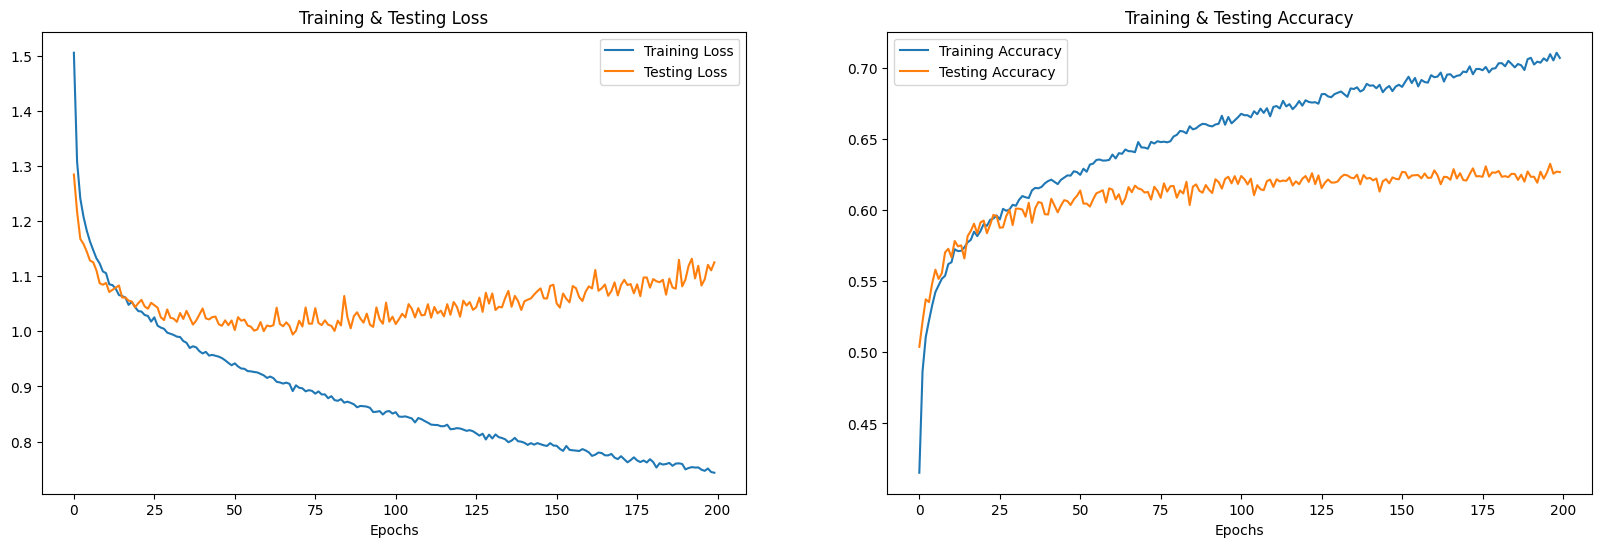

In [38]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [67]:
audio_path = 'audiorecord.webm'
data, _ = librosa.load(audio_path, duration=2.5, offset=0.6)
emotion_prediction = model.predict(np.expand_dims(np.array([extract_features(data)]), axis=2))
print("Prediction:", encoder.inverse_transform(emotion_prediction.reshape(1, -1))[0][0].upper())

NoBackendError: 

In [61]:
# predicting on test data.
pred_test = model.predict(x_test)
print(x_test.shape)
# y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)

(9122, 162, 1)


In [52]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,disgust
1,disgust,disgust
2,angry,angry
3,disgust,disgust
4,neutral,fear
5,sad,fear
6,sad,happy
7,happy,happy
8,disgust,sad
9,neutral,sad


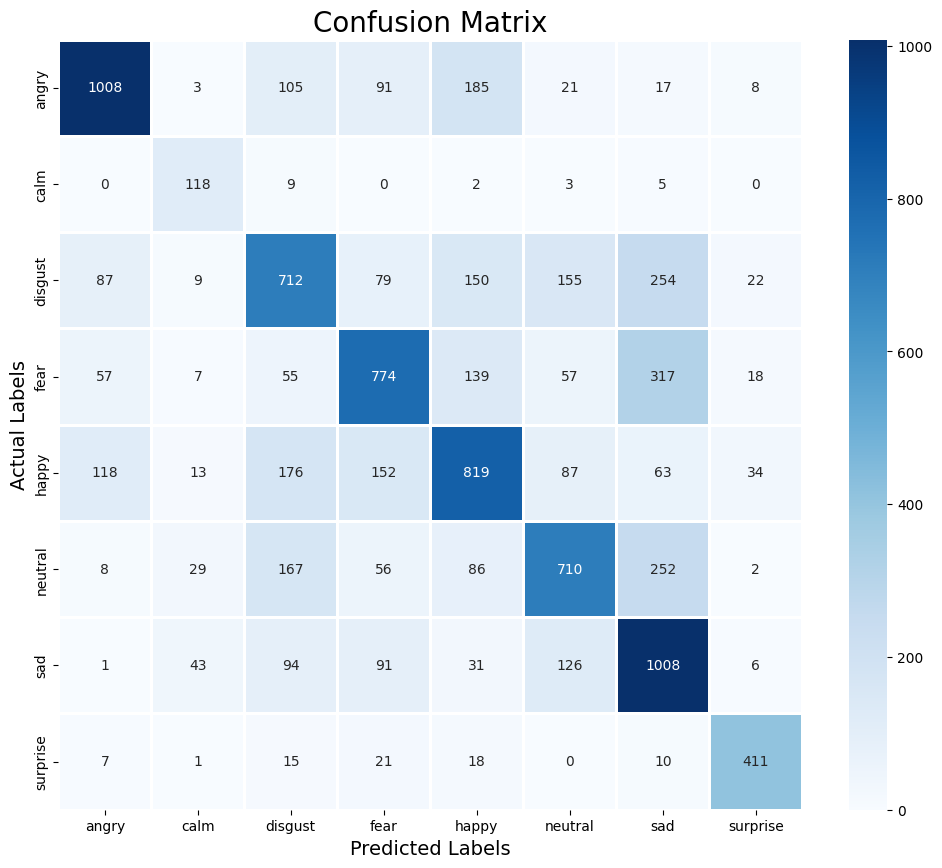

In [53]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.78      0.70      0.74      1438
        calm       0.53      0.86      0.66       137
     disgust       0.53      0.49      0.51      1468
        fear       0.61      0.54      0.58      1424
       happy       0.57      0.56      0.57      1462
     neutral       0.61      0.54      0.58      1310
         sad       0.52      0.72      0.61      1400
    surprise       0.82      0.85      0.84       483

    accuracy                           0.61      9122
   macro avg       0.62      0.66      0.63      9122
weighted avg       0.62      0.61      0.61      9122



---------------------------------------------------------------------------------------------------------------

- [ ] Muat Dataset

In [ ]:
print("Hello")


- [ ] Pra proses

- [ ] Split Data (Train&Val)

- [ ] Define ML Model

- [ ] Train da model

- [ ] Evaluate

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e3e1d63-2a55-4dcb-8826-d15658c6a54b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>